In [1]:
import sys
import time
import gensim
import re
import nltk
import os
import gzip

import pandas as pd
import numpy as np

from PIL import Image
from gensim.models import word2vec

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity


import matplotlib.pyplot as plt
from matplotlib import offsetbox
from mpl_toolkits.mplot3d import Axes3D


import datafold.pcfold as pfold
from datafold.dynfold import DiffusionMaps
from datafold.utils.plot import plot_pairwise_eigenvector

from utils.utils import Loaders, Plotters

In [2]:
# Load  generated vadere data
df = pd.read_csv('postviz_.csv')
ids = pd.read_csv('out_.csv')
X_data = []
Y_data = []
X_data_test = []
Y_data_test = []
i = 0
for pd_id, src in ids.iterrows():
    if i > 1400:
        X = (df[df.pedestrianId == pd_id]["x-PID1"].to_numpy()).astype(int)
        Y = (df[df.pedestrianId == pd_id]["y-PID1"].to_numpy()).astype(int)
        q = np.zeros((50,50))
        q[X,Y] = 1
        X_data_test.append(q.flatten())
        Y_data_test.append(src["sourceId-PID5"])
    else:
        X = (df[df.pedestrianId == pd_id]["x-PID1"].to_numpy()).astype(int)
        Y = (df[df.pedestrianId == pd_id]["y-PID1"].to_numpy()).astype(int)
        q = np.zeros((50,50))
        q[X,Y] = 1
        X_data.append(q.flatten())
        Y_data.append(src["sourceId-PID5"])
    i += 1
    

In [3]:
ids

,pedestrianId,sourceId-PID5
0,1,1
1,2,6
2,3,3
3,4,2
4,5,4
...,...,...
1595,1596,2
1596,1597,4
1597,1598,5
1598,1599,7


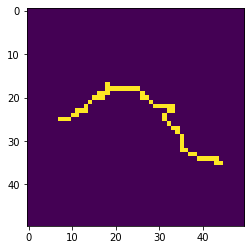

In [4]:
pd_id = 30
c = ids[ids.pedestrianId == pd_id]["sourceId-PID5"].to_numpy()[0]
X = (df[df.pedestrianId == pd_id]["x-PID1"].to_numpy()).astype(int)
Y = (df[df.pedestrianId == pd_id]["y-PID1"].to_numpy()).astype(int)
q = np.zeros((50,50))
q[X,Y] += 1
plt.imshow(q, interpolation='nearest')
plt.savefig(f"trajs/tra_{pd_id}_c{c}.png")
plt.show()

epsilon=25.406227191340232, cut-off=21.633307652783937


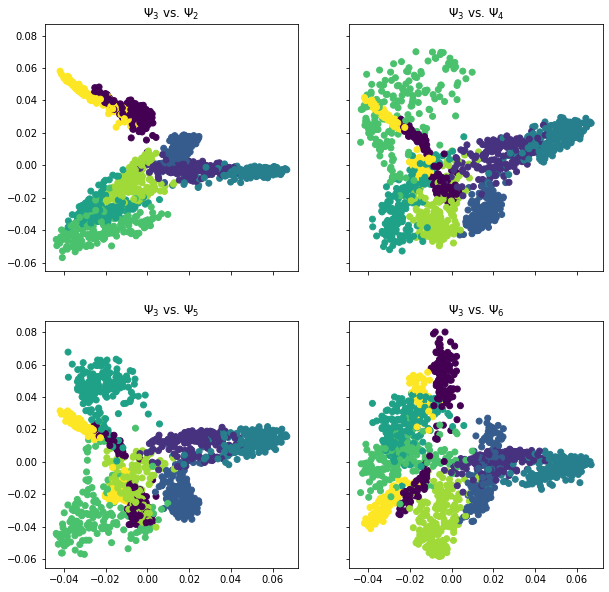

In [5]:
X_pcm = pfold.PCManifold(X_data)
X_pcm.optimize_parameters(result_scaling=2)

print(f'epsilon={X_pcm.kernel.epsilon}, cut-off={X_pcm.cut_off}')

t0 = time.time()
dmap = DiffusionMaps(kernel=pfold.GaussianKernel(epsilon=X_pcm.kernel.epsilon),
                     n_eigenpairs=6, dist_kwargs=dict(cut_off=X_pcm.cut_off))

dmap_ = dmap.fit(X_pcm)

plot_pairwise_eigenvector(eigenvectors=dmap.eigenvectors_[:, 1:],
                          n=1,
                          idx_start=2,
                          fig_params=dict(figsize=(10,10)),
                          scatter_params=dict(c=Y_data))


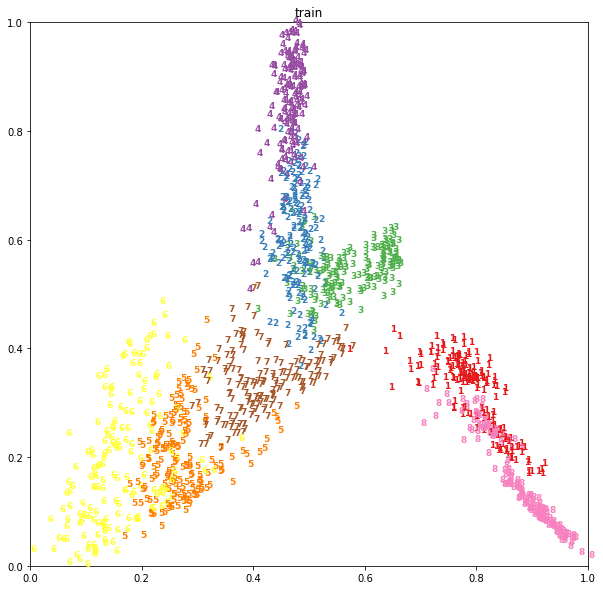

In [6]:
dmap = dmap_.set_coords([1, 2])
X_dmap_pid = dmap.transform(X_pcm)
Plotters.plot_embedding_pids(X_dmap_pid, Y_data, title="train")

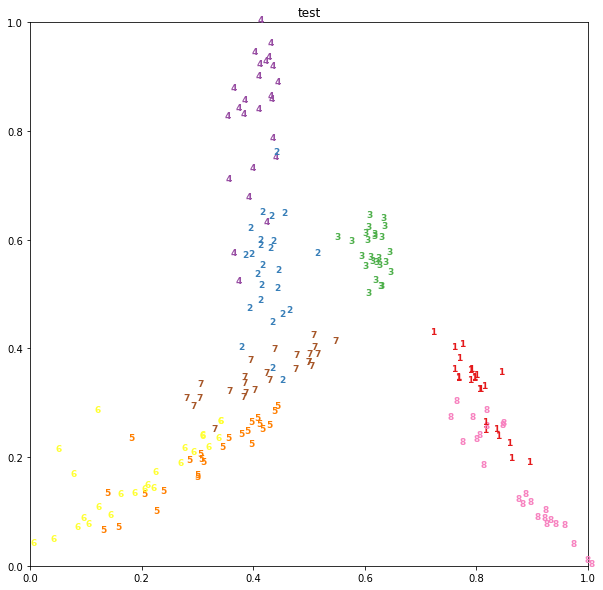

In [7]:
X_dmap_test = dmap.transform(X_data_test)
Plotters.plot_embedding_pids(X_dmap_test, Y_data_test, title="test")

In [8]:

X_pcm = pfold.PCManifold(X_data)
X_pcm.optimize_parameters(result_scaling=3)

print(f'epsilon={X_pcm.kernel.epsilon}, cut-off={X_pcm.cut_off}')

t0 = time.time()
dmap = DiffusionMaps(kernel=pfold.GaussianKernel(epsilon=X_pcm.kernel.epsilon),
                     n_eigenpairs=6, dist_kwargs=dict(cut_off=X_pcm.cut_off))

dmap_ = dmap.fit(X_pcm)

dmap = dmap_.set_coords([1, 2, 3])
X_dmap_pid = dmap.transform(X_pcm)



epsilon=57.164011180515516, cut-off=32.449961479175904


In [9]:
%matplotlib widget
Plotters.plot_embedding_pids_3d(X_dmap_pid, Y_data, title='train')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [10]:
X_dmap_test = dmap.transform(X_data_test)
Plotters.plot_embedding_pids_3d(X_dmap_test, Y_data_test, title="test")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [11]:
from sklearn.cluster import KMeans
kmeans = KMeans(8, random_state=0)
labels = kmeans.fit(X_dmap_pid).predict(X_dmap_pid)


In [12]:
Plotters.plot_embedding_pids_3d(X_dmap_pid, labels, title="kmeans")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [13]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=8).fit(X_dmap_pid)
labels = gmm.predict(X_dmap_pid)

In [14]:
Plotters.plot_embedding_pids_3d(X_dmap_pid, labels, title="GMM")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …